In [1]:
%matplotlib inline

import numpy as np
import math
from datetime import timedelta
from operator import attrgetter
import xarray as xr
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker


In [2]:
import parcels
parcels.__version__ # para saber la versión del paquete parcels que estamos usando

'3.1.0'

In [3]:
filedir = '/home/jovyan/shared/ohwe24_hackaton/proy2/'

In [4]:
!ls /home/jovyan/shared/ohwe24_hackaton/proy2/

cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-I_19980101.nc
mercatorbiomer4v2r1_global_mean_bio_20220101.nc
mercatorbiomer4v2r1_global_mean_bio_20220102.nc
mercatorbiomer4v2r1_global_mean_bio_20220103.nc
mercatorbiomer4v2r1_global_mean_bio_20240101.nc
mercatorbiomer4v2r1_global_mean_bio_20240102.nc
mercatorbiomer4v2r1_global_mean_bio_20240103.nc
mercatorbiomer4v2r1_global_mean_bio_20240104.nc
mercatorbiomer4v2r1_global_mean_bio_20240105.nc
mercatorbiomer4v2r1_global_mean_bio_20240106.nc
mercatorbiomer4v2r1_global_mean_bio_20240107.nc
mercatorbiomer4v2r1_global_mean_bio_20240108.nc
mercatorbiomer4v2r1_global_mean_bio_20240109.nc
mercatorbiomer4v2r1_global_mean_bio_20240110.nc
mercatorbiomer4v2r1_global_mean_bio_20240111.nc


In [10]:
ds_m = xr.open_dataset(filedir + 'cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-I_19980101.nc')

In [20]:
!pwd

/home/jovyan


In [11]:
ds_m

<xarray.Dataset> Size: 846MB
Dimensions:              (latitude: 2040, longitude: 4320, time: 1, depth: 3)
Coordinates:
  * latitude             (latitude) float32 8kB -80.0 -79.92 ... 89.83 89.92
  * longitude            (longitude) float32 17kB -180.0 -179.9 ... 179.8 179.9
  * time                 (time) datetime64[ns] 8B 1998-01-01T12:00:00
  * depth                (depth) int32 12B 1 2 3
Data variables:
    T                    (time, depth, latitude, longitude) float64 212MB ...
    U                    (time, depth, latitude, longitude) float64 212MB ...
    V                    (time, depth, latitude, longitude) float64 212MB ...
    pelagic_layer_depth  (time, depth, latitude, longitude) float64 212MB ...
Attributes:
    title:                      Physical forcings of global ocean low and mid...
    source:                     SEAPODYM-LMTL 3.0.0
    references:                 http://www.cls.fr; http://www.seapodym.eu
    institution:                CLS
    Conventions:                CF-1.7
    source_physical_variables:  GLOBAL_REANALYSIS_PHY_001_030 CMEMS product
    spatial_resolution:         0.083x0.083
    temporal_resolution:        1 day
    domain:                     global
    date_field:                 19980101
    history:                    Created on 2022-09-28

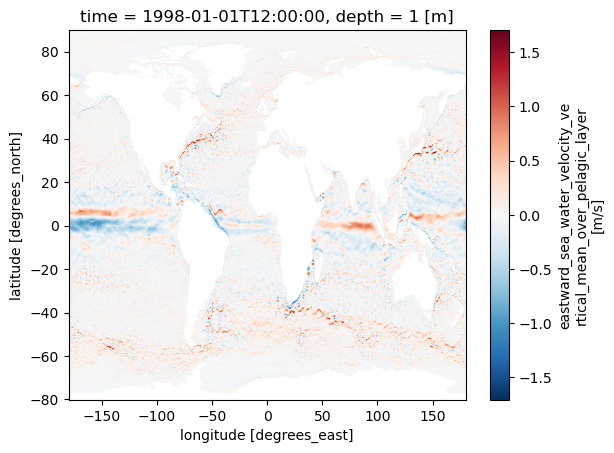

In [12]:
ds_m.U[0,0:,:].plot()

In [13]:
lon_min = -76
lon_max = -72
lat_min = -44
lat_max = -41

In [14]:
ds_m_sub = ds_m.where((ds_m.longitude<lon_max)&(ds_m.longitude>lon_min)&(ds_m.latitude<lat_max)&(ds_m.latitude>lat_min), drop=True)


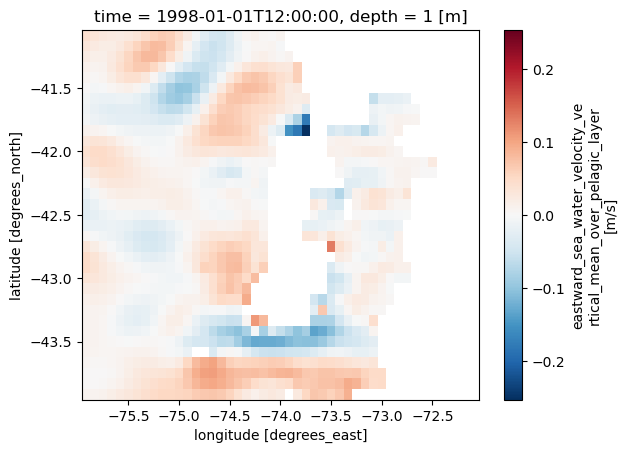

In [16]:
ds_m_sub.U[0,0,:,:].plot()

In [17]:
ficheros = {'U': filedir + "cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-I_2023010[0-1]?_*.nc",
             'V': filedir + "cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-I_2023010[0-1]?_*.nc"}#cargamos la veloc para las simulaciones


In [18]:
variables = {'U': 'U',
             'V': 'V'}

dimensiones = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

In [19]:
fieldset = FieldSet.from_netcdf(ficheros, variables, dimensiones, deferred_load=False)

OSError: FieldSet files not found for variable U: /home/jovyan/shared/ohwe24_hackaton/proy2/cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-I_2023010[0-1]?_*.nc

In [31]:
lon1D = fieldset.U.lon[np.arange(320, 330, 1)]
lat1D = fieldset.U.lat[np.arange(380, 390, 1)]

lons, lats = np.meshgrid(lon1D, lat1D)
pset_B = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats)

/home/.pixi/envs/default/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


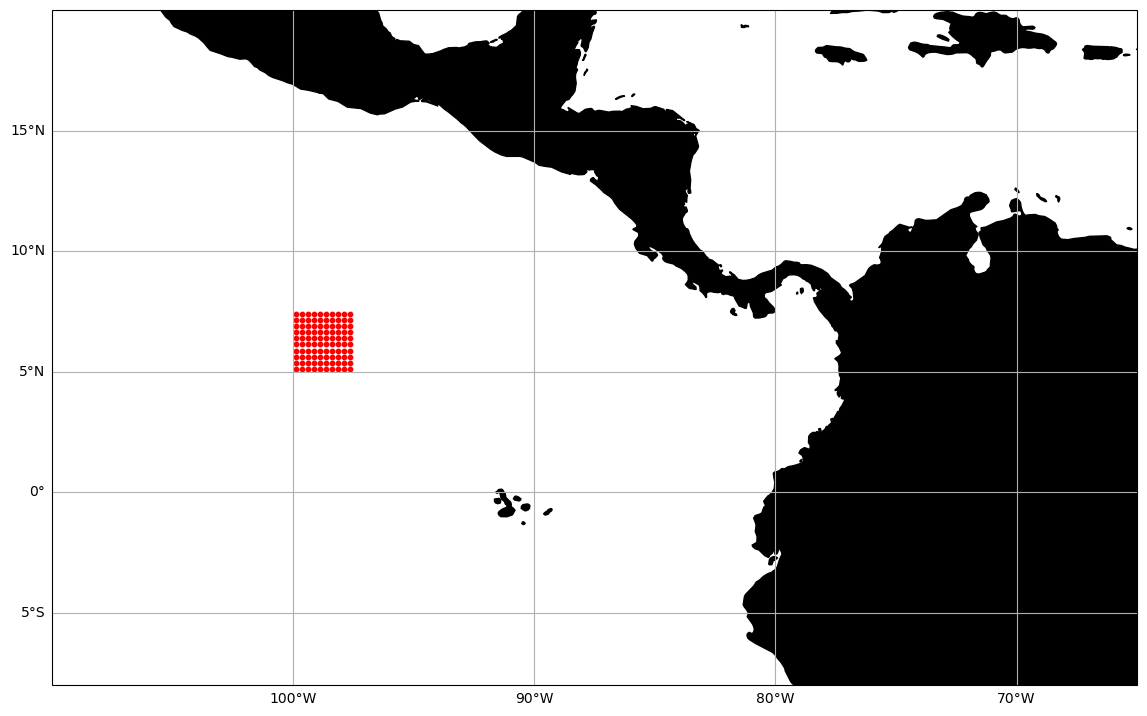

In [32]:
plt.figure(figsize=(14,10))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
ax1.add_feature(cartopy.feature.LAND, facecolor='black') # si el codigo tarda mucho, se puede comentar esta línea
ax1.scatter(pset_B.lon, pset_B.lat, c='r', s=10, transform=ccrs.PlateCarree(), label='Start')
ax1.set_xlim([lon_min-10., lon_max+10.])
ax1.set_ylim([lat_min-10., lat_max+10.])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER#esta celda con la anterior se define cuantas y donde se lanzan las particulas


In [33]:
runtime_days = 10#dias que corre

In [34]:
fichero_salida_B = "lag_simu_pset_B_test01" # fichero guardado en formato .zarr que es equivalente a netcdf (.nc)

In [35]:
output_file = pset_B.ParticleFile(name=fichero_salida_B, outputdt=timedelta(hours=24))
pset_B.execute(pset_B.Kernel(AdvectionRK4),
             runtime=timedelta(days=runtime_days),
             dt=timedelta(minutes=25),
             output_file=output_file)

INFO: Output files are stored in lag_simu_pset_B_test01.zarr.
100%|██████████| 864000.0/864000.0 [00:04<00:00, 204131.06it/s]


In [36]:
!ls -trl # para ver los nuevos ficheros en nuestro directorio

total 632
drwxr-xr-x 16 jovyan jovyan   4096 Nov 15 15:19 shared
-rw-r--r--  1 jovyan jovyan    617 Nov 25 15:33 Untitled.ipynb
-rw-r--r--  1 jovyan jovyan    617 Nov 25 17:31 Untitled1.ipynb
drwxr-xr-x  4 jovyan jovyan   4096 Nov 25 18:11 ohwe24-proy2-plasticos
drwxr-xr-x  6 jovyan jovyan   4096 Nov 25 18:47 tutorialesOHW2024
-rw-r--r--  1 jovyan jovyan    617 Nov 25 19:36 Untitled2.ipynb
-rw-r--r--  1 jovyan jovyan  24055 Nov 26 12:01 Untitled4.ipynb
drwxr-xr-x  3 jovyan jovyan   4096 Nov 26 14:10 R
-rw-r--r--  1 jovyan jovyan 586457 Nov 26 18:36 Untitled3.ipynb
drwxr-xr-x  8 jovyan jovyan   4096 Nov 26 18:37 lag_simu_pset_B_test01.zarr


In [37]:
ds = xr.open_dataset("lag_simu_pset_B_test01.zarr")

/home/.pixi/envs/default/lib/python3.12/site-packages/xarray/backends/plugins.py:149: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/.pixi/envs/default/lib/python3.12/site-packages/xarray/backends/plugins.py:149: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [38]:
ds

<xarray.Dataset> Size: 21kB
Dimensions:     (trajectory: 100, obs: 10)
Coordinates:
  * obs         (obs) int32 40B 0 1 2 3 4 5 6 7 8 9
  * trajectory  (trajectory) int64 800B 100 101 102 103 104 ... 196 197 198 199
Data variables:
    lat         (trajectory, obs) float32 4kB ...
    lon         (trajectory, obs) float32 4kB ...
    time        (trajectory, obs) datetime64[ns] 8kB ...
    z           (trajectory, obs) float32 4kB ...
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4
    parcels_mesh:           spherical
    parcels_version:        3.1.0

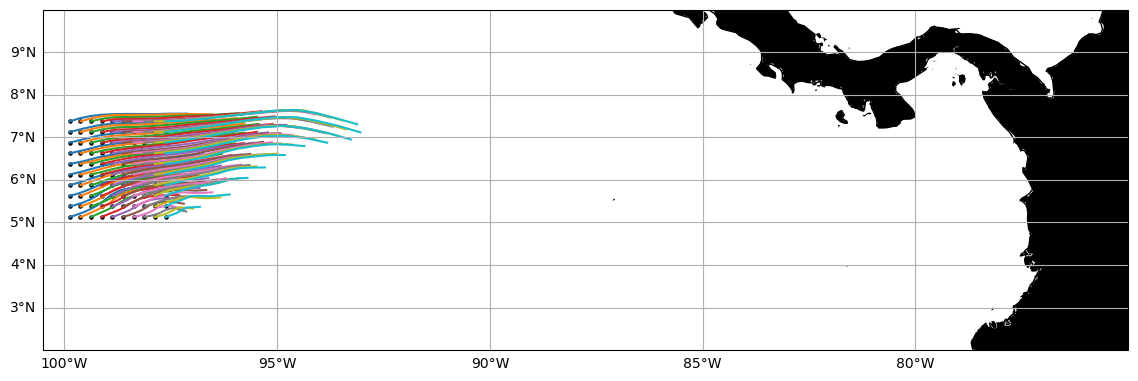

In [39]:
plt.figure(figsize=(14,10))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
ax1.add_feature(cartopy.feature.LAND, facecolor='black') # si el codigo tarda mucho, se puede comentar esta línea
ax1.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree())
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=5, transform=ccrs.PlateCarree(), label='Start')
ax1.set_xlim([lon_min-0.5, lon_max])
ax1.set_ylim([lat_min, lat_max])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


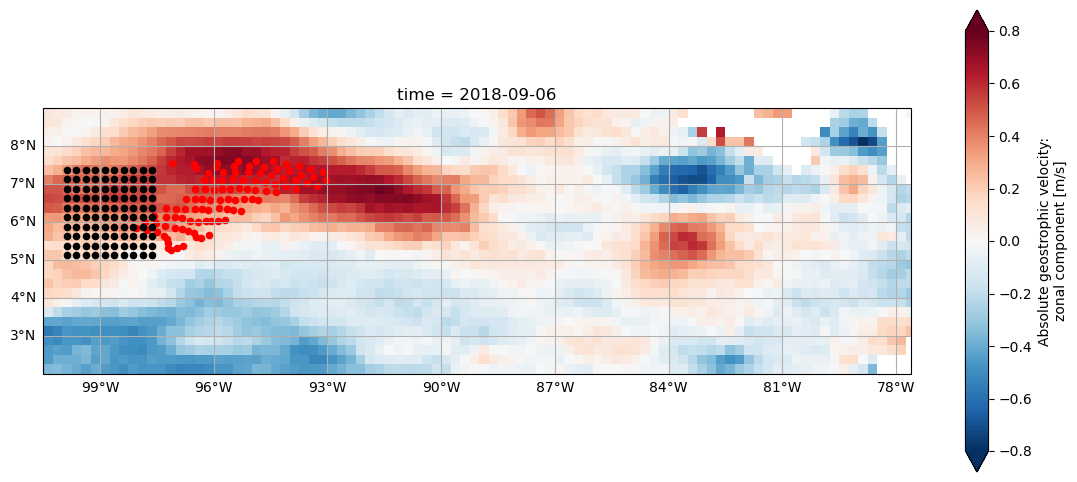

In [40]:
plt.figure(figsize=(14,6))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ds_m.ugos[0,:,:].plot(vmin=-.8, vmax=.8, cmap='RdBu_r')
ax1.scatter(ds['lon'][:,-1], ds['lat'][:,-1], c='r', s=20, transform=ccrs.PlateCarree(), label='End')
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=20, transform=ccrs.PlateCarree(), label='Start')
ax1.set_xlim([lon_min-0.5, -77.6])
ax1.set_ylim([lat_min, 9])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
